### Cross Validation

In [1]:
import numpy as np
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from sklearn.model_selection import train_test_split

In [2]:
from functools import partial
from sklearn.model_selection import \
    (cross_validate,
     KFold,
     ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm

In [3]:
Auto = load_data('Auto')
Auto_train, Auto_valid = train_test_split(Auto,
                                            test_size=196,
                                            random_state=0)

In [4]:
hp_mm = MS(['horsepower'])
X_train = hp_mm.fit_transform(Auto_train)
y_train = Auto_train['mpg']
model = sm.OLS(y_train, X_train)
results = model.fit()

In [5]:
X_valid = hp_mm.transform(Auto_valid)
y_valid = Auto_valid['mpg']
valid_pred = results.predict(X_valid)
np.mean((valid_pred - y_valid) ** 2)

np.float64(23.616617069669893)

In [6]:
def evalMSE(terms,
            response,
            train,
            test):
    mm = MS(terms)
    X_train = mm.fit_transform(train)
    y_train = train[response]
    
    X_test = mm.transform(test)
    y_test = test[response]
    
    results = sm.OLS(y_train, X_train).fit()
    test_pred = results.predict(X_test)
    
    return np.mean((y_test - test_pred) ** 2)

In [7]:
MSE = np.zeros(3)
for idx, degree in enumerate(range(1, 4)):
    MSE[idx] = evalMSE([poly('horsepower', degree)],
                       'mpg',
                       Auto_train,
                       Auto_valid)
MSE

array([23.61661707, 18.76303135, 18.79694163])

In [8]:
hp_model = sklearn_sm(sm.OLS,
                      MS(['horsepower']))
X, Y = Auto.drop(columns='mpg'), Auto['mpg']
cv_results = cross_validate(hp_model,
                            X,
                            Y,
                            cv=Auto.shape[0])
cv_err = np.mean(cv_results['test_score'])
cv_err

np.float64(24.231513517929226)

Notes: cross validation is a good method for trying to avoid overfitting. It is a way to test the model on different data sets. This applies particularly with smaller datasets as this allows a greater number of combinations of data.

### Boostrapping

In [9]:
Portfolio = load_data('Portfolio')
def alpha_func(D, idx):
    cov_ = np.cov(D[['X', 'Y']].loc[idx], rowvar=False)
    return ((cov_[1,1] - cov_[0,1]) /
            (cov_[0,0] + cov_[1,1]-2*cov_[0,1]))

In [10]:
alpha_func(Portfolio, range(100))

np.float64(0.57583207459283)

In [11]:
rng = np.random.default_rng(0)
alpha_func(Portfolio,
           rng.choice(100,
                      100,
                      replace=False))

np.float64(0.5758320745928298)

In [12]:
def boot_SE(func,
            D,
            n=None,
            B=1000,
            seed=0):
    rng = np.random.default_rng(seed)
    first_, second_ = 0,0
    n = n or D.shape[0]
    for _ in range (B):
        idx = rng.choice(D.index,
                         n,
                         replace=True)
        value = func(D, idx)
        first_ += value
        second_ += value**2
    return np.sqrt(second_ / B - (first_ / B) ** 2)

In [13]:
alpha_SE = boot_SE(alpha_func,
                   Portfolio,
                   B=1000,
                   seed=0)
alpha_SE

np.float64(0.09118176521277699)

#### Stepwise Regression

In [14]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)

In [16]:
Hitters = load_data('Hitters')

np.isnan(Hitters['Salary']).sum()

np.int64(59)

In [17]:
Hitters = Hitters.dropna()
Hitters.shape

(263, 20)

In [18]:
def nCp(sigma2, estimator, X, Y):
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat) ** 2)
    return -(RSS + 2 * p * sigma2) / n

In [19]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale

In [20]:
neg_Cp = partial(nCp, sigma2)

In [21]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

In [22]:
hitters_MSE = sklearn_selected(OLS,
                               strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [23]:
hitters_Cp = sklearn_selected(OLS,
                              strategy,
                              scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

In [24]:
strategy = Stepwise.fixed_steps(design,
                               len(design.terms),
                                 direction='forward')
full_path = sklearn_selection_path(OLS, strategy)

In [25]:
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

(50000.0, 250000.0)

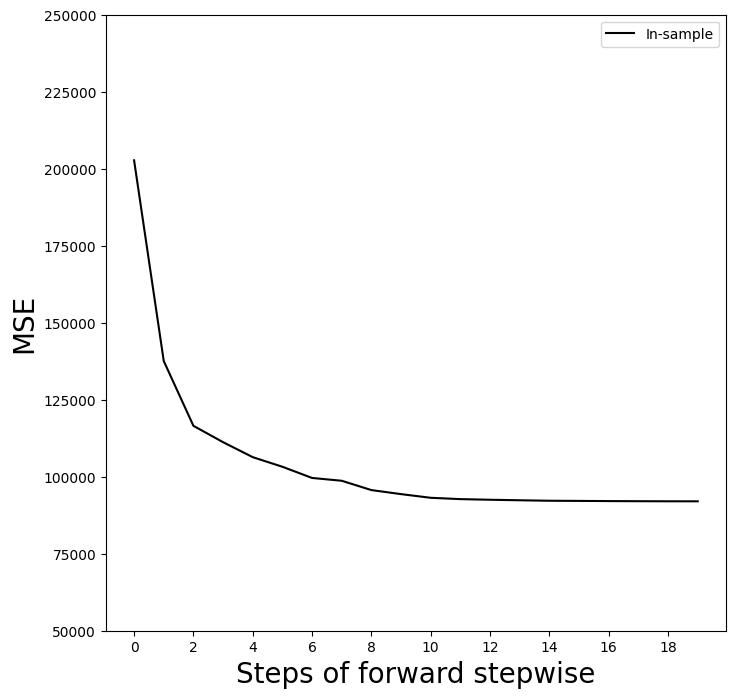

In [26]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k',
        label='In-sample')
ax.set_ylabel('MSE', fontsize=20)
ax.set_xlabel('Steps of forward stepwise', fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000, 250000])

In [27]:
K = 5
kfold = skm.KFold(n_splits=K, shuffle=True, random_state=0)

Yhat_cv = skm.cross_val_predict(full_path,
                                Hitters,
                                Y, cv=kfold)

Yhat_cv.shape

(263, 20)

In [28]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx, None]) ** 2
    cv_mse.append(errors.mean(0))
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

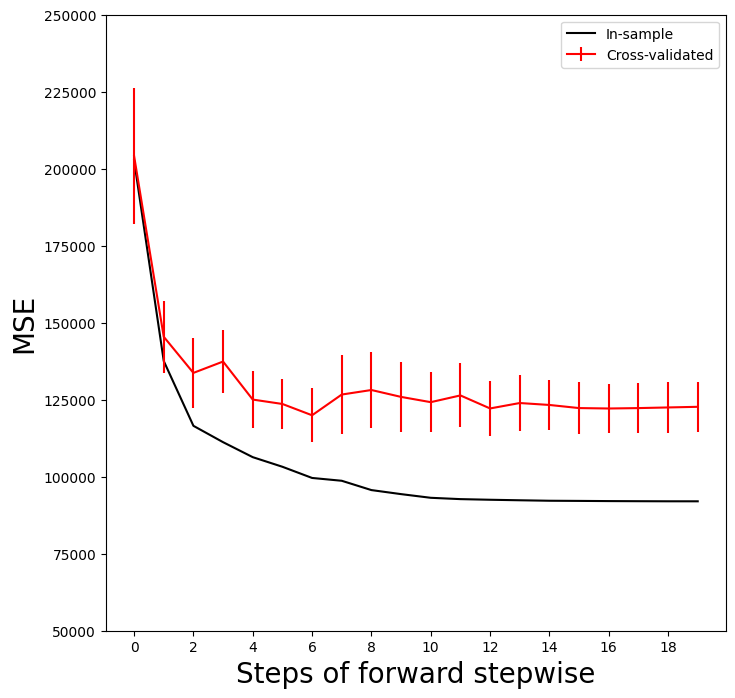

In [29]:
ax.errorbar(np.arange(n_steps),
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label='Cross-validated',
            color='r')
ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

In [32]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size = 0.2,
                                random_state=0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx],Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx, None])**2
    validation_mse = errors.mean(0)

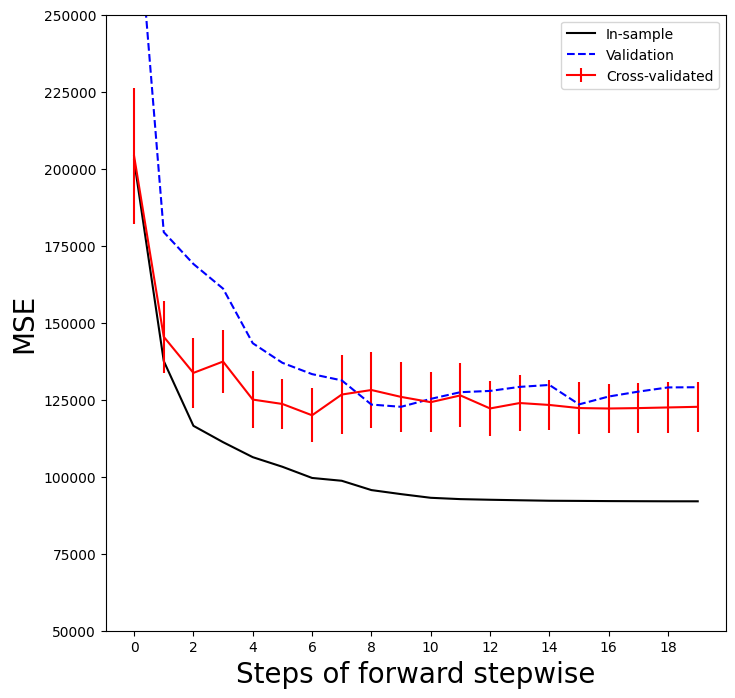

In [33]:
ax.plot(np.arange(n_steps),
        validation_mse,
        'b--',
        label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000, 250000])
ax.legend()
mse_fig